# Evaluation of artifical sequence data based on Categorical Mixture Models

This notebook shows how the evaluation for our generative model was performed.

## Section 1: Setup

In [1]:
from gentype import EnsemblClient, DataManager, PiCollapsedNonparametricGibbsSampler
from gentype import AlleleMM, write_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

Set up Classes:

In [2]:
Database_Name = "Gentype_HLA_DB.db"
client = EnsemblClient()
data_manager = DataManager(client, Database_Name)

Setting the paramaters for our selected allele: HLA-A. For options for ref_name and population_name you can also take a look at the database after fetching.

In [3]:
region_start = 29941260
region_end = 29945884
ref_name = "6" # generally the name of the chromosome
population_name = "ALL"
project_name = "1000GENOMES:phase_3"
allele_args = {'start' : region_start, 'end' : region_end, 'reference_name' : ref_name, 'population' : population_name, 'project' : project_name}

We use store magic to store the values of costly computations (data fetching, model training), so they only have to be done once.

Initialize storable data:

In [4]:
fetched = False
inference_matrix = None
models = None

Restore stored data (remove # to recompute instead of restore respective data):

In [5]:
%store -d fetched # if you want to refetch the data, uncomment this line
%store -d inference_matrix # if you want to recompute the inference_matrix, uncomment this line
%store -d models # if you want to recompute the models, uncomment this line
%store -r

## Section 2: Collecting and preparing data

Fetches all HLA-A data obtained in 1000 Genomes project phase3 and stores them in a local sqlite server. This only needs to be done once but might take a while.

In [6]:
if not fetched:
    data_manager.fetch_all(region_start, region_end, ref_name, report_progress = True)
fetched = True
%store fetched

Finished fetching reference set.
Finished fetching reference sequences for set: GRCh38.
Finished fetching populations for species: homo_sapiens.
Finished fetching individuals for population: African Caribbean in Barbados.
Finished fetching individuals for population: African.
Finished fetching individuals for population: All phase 3 individuals.
Finished fetching individuals for population: American.
Finished fetching individuals for population: African Ancestry in Southwest US.
Finished fetching individuals for population: Bengali in Bangladesh.
Finished fetching individuals for population: Chinese Dai in Xishuangbanna, China.
Finished fetching individuals for population: Utah residents with Northern and Western European ancestry.
Finished fetching individuals for population: Han Chinese in Bejing, China.
Finished fetching individuals for population: Southern Han Chinese, China.
Finished fetching individuals for population: Colombian in Medellin, Colombia.
Finished fetching individual

Finished fetching 10 variants next is 135828981.
Finished fetching 10 variants next is 135829269.
Finished fetching 10 variants next is 135829578.
Finished fetching 10 variants next is 135829920.
Finished fetching 10 variants next is 135830275.
Finished fetching 10 variants next is 135830753.
Finished fetching 10 variants next is 135831020.
Finished fetching 10 variants next is 135831291.
Finished fetching 10 variants next is 135831511.
Finished fetching 10 variants next is 135831832.
Finished fetching 10 variants next is 135832041.
Finished fetching 10 variants next is 135832658.
Finished fetching 10 variants next is 135833032.
Finished fetching 10 variants next is 135833505.
Finished fetching 10 variants next is 135833734.
Finished fetching 10 variants next is 135834056.
Finished fetching 10 variants next is 135834479.
Finished fetching 10 variants next is 135834943.
Finished fetching 10 variants next is 135835316.
Finished fetching 10 variants next is 135835500.
Finished fetching 10

The following generates an inference matrix from the data provided by the local database. The inference matrix can be constructed with respect to a population and a section specified by start and end. Be sure to fetch the according population before constructing the matrix. 

Each row in the matrix represents the variants present in each individual as a bitvector.

In [7]:
if inference_matrix is None:
    inference_matrix, individual_map, variation_map = data_manager.generate_inference_matrix(**allele_args)
%store inference_matrix 
%store individual_map 
%store variation_map
inference_matrix.shape

Stored 'inference_matrix' (ndarray)
Stored 'individual_map' (dict)
Stored 'variation_map' (dict)


(5008, 1429)

We then split the matrix into a training and a test set.

In [8]:
split_point = int(len(inference_matrix) - len(inference_matrix)/3)
# if we want to keep using our mapping we need to use the first half for training
inference_matrix_training = inference_matrix[:split_point]
inference_matrix_test = inference_matrix[split_point:]

In the PCA plot we can see that our training and test sets are fairly evenly distributed.

[0.35828123 0.61805429]


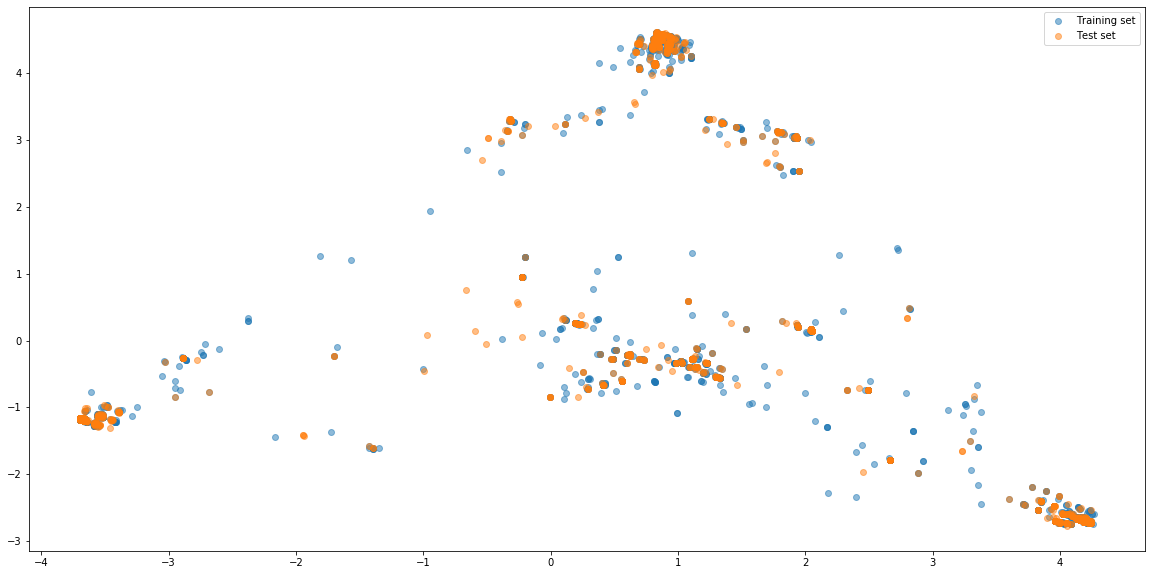

In [9]:
fig, ax = plt.subplots(figsize = (20,10))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(inference_matrix)
print(pca.explained_variance_ratio_.cumsum())
ax.plot(principalComponents[:split_point,0], principalComponents[:split_point,1], "o", alpha=0.5)
ax.plot(principalComponents[split_point:,0], principalComponents[split_point:,1], "o", alpha=0.5)
ax.legend(["Training set", "Test set"])

## Section 3: Training the Model

Train models with different initializations without seeding.

Here we compute different models with varying dirichlet prior alpha. This prior is proportional to the probability of creating a new cluster, therefore inference with high alphas tends to begin with a higher number of clusters. This might take a while.

In [ ]:
alphas = [0.1,1,10]
gammas = [0.05, 0.1, 0.5, 1]
if models is None:
    models = [PiCollapsedNonparametricGibbsSampler() for i in range(len(alphas) * len(gammas))]
    i = 0
    for alpha in alphas:
        for gamma in gammas:
                models[i].fit(inference_matrix_training, num_burn_in_steps = 20, num_steps=20, delta = 2, alpha = alpha, gamma = gamma)
                i+=1
%store models

Iteration: 1; Current clusters: 49; Likelihood: -953466.932
Iteration: 2; Current clusters: 44; Likelihood: -951818.003
Iteration: 3; Current clusters: 43; Likelihood: -951167.079
Iteration: 4; Current clusters: 41; Likelihood: -950859.574
Iteration: 5; Current clusters: 40; Likelihood: -950767.071
Iteration: 6; Current clusters: 40; Likelihood: -950729.158
Iteration: 7; Current clusters: 40; Likelihood: -950611.163
Iteration: 8; Current clusters: 39; Likelihood: -950598.358
Iteration: 9; Current clusters: 38; Likelihood: -950575.620
Iteration: 10; Current clusters: 37; Likelihood: -950434.347
Iteration: 11; Current clusters: 37; Likelihood: -950404.899
Iteration: 12; Current clusters: 37; Likelihood: -950265.799
Iteration: 13; Current clusters: 37; Likelihood: -950356.267
Iteration: 14; Current clusters: 37; Likelihood: -950241.776
Iteration: 15; Current clusters: 37; Likelihood: -950248.708
Iteration: 16; Current clusters: 37; Likelihood: -950304.264
Iteration: 17; Current clusters: 

Iteration: 21; Current clusters: 4; Likelihood: -1001605.748
Iteration: 22; Current clusters: 4; Likelihood: -1001558.255
Iteration: 23; Current clusters: 4; Likelihood: -1001567.554
Iteration: 24; Current clusters: 4; Likelihood: -1001514.030
Iteration: 25; Current clusters: 4; Likelihood: -1001467.508
Iteration: 26; Current clusters: 4; Likelihood: -1001569.754
Iteration: 27; Current clusters: 4; Likelihood: -1001547.072
Iteration: 28; Current clusters: 4; Likelihood: -1001573.593
Iteration: 29; Current clusters: 4; Likelihood: -1001516.456
Iteration: 30; Current clusters: 4; Likelihood: -1001415.565
Iteration: 31; Current clusters: 4; Likelihood: -1001339.463
Iteration: 32; Current clusters: 4; Likelihood: -1001616.373
Iteration: 33; Current clusters: 4; Likelihood: -1001561.417
Iteration: 34; Current clusters: 4; Likelihood: -1001557.389
Iteration: 35; Current clusters: 4; Likelihood: -1001672.760
Iteration: 36; Current clusters: 4; Likelihood: -1001546.622
Iteration: 37; Current c

In [ ]:
for i, model in enumerate(models):
    print("Model {}:".format(i))
    plt.clf()
    plt.plot(models[i].ll_list)
    plt.show()

May pre select models e.g. according to Aitikens Information Criterion (AIC).

In [ ]:
def compute_AIC(model):
    size = np.prod(np.shape(model.theta))
    loglikelihood =model.ll_list[-1]
    return 2*size - 2*loglikelihood
values = list(map(lambda x: compute_AIC(x), models))
AIC = sorted(zip(values, range(len(values)), list(map(lambda x: x.K_seen, models))), key = lambda x: x[0])
for a in AIC:
    print("AIC: {} Model: {} Cluster {}".format(a[0], a[1], a[2]))

## Section 4: Generative Validation

In this section we run the evaluation of our models. In the following a sample refers to an artifical sequence.

In [ ]:
from gentype import AlleleMM, get_distances

First we define the Kullback–Leibler divergence:

In [ ]:
def KL_div(p, q):
    return np.nan_to_num([p[i] * np.log(p[i]/q[i]) for i in range(len(p))]).sum()

The following function takes samples from the given model and turns them into the respective characteristic vector for further analysis.

In [ ]:
def sample(number_of_samples, eval_model):
    variant_ranges = data_manager.get_variation_range(**allele_args)
    mm = AlleleMM(eval_model.Z, eval_model.theta, inference_matrix_training, variant_ranges, variation_map)
    number_of_samples = number_of_samples
    samples = []
    clusters = []
    descriptions = []
    for i in range(number_of_samples):
        characteristic_vector = np.zeros(len(eval_model.theta[0]))
        sample, cluster = mm.sample_variations(return_cluster = True)
        characteristic_vector[sample] = 1
        samples.append(characteristic_vector)
        clusters.append(cluster)

    return samples, clusters, descriptions

Create artificial sequences from every model we have created.

In [ ]:
SAMPLE_SIZE = 200
samplings = []
for model in models:
    samplings.append(sample(SAMPLE_SIZE, model))

The following function evaluates our metrics m_D and m_S and returns them.

In [ ]:
def evaluate(samples):
    assigned_distance, distributions, assignments = get_distances(samples, inference_matrix_test, return_assignments = True)

    sum_distances = 0
    for sample in samples:
        sum_distances += assigned_distance[tuple(sample)]
    avg_distances = sum_distances/len(samples)

    distribution_difference = 0
    test_probabilites = []
    generated_probabilites = []
    test_set = [tuple(individual) for individual in inference_matrix_test]
    for individual in set(test_set):
        test_quota, generated_quota = distributions[individual]
        test_probabilites.append(test_quota)
        generated_probabilites.append(generated_quota)
        distribution_difference += np.absolute(test_quota - generated_quota)

    return avg_distances, distribution_difference, KL_div(generated_probabilites, test_probabilites)

Evaluate each set of artificial sequences.

In [ ]:
evaluations = []
for samples in samplings:
    evaluations.append(evaluate(samples[0]))

Show a table of the average distances (m_S) for each of the models:

In [ ]:
alphas_dict = {}
for i in range(len(alphas)):
    gamma_evals = []
    for j in range(len(gammas)):
        evaluation = evaluations[(i*len(gammas)) + j]
        gamma_evals.append(evaluation[0])
    alphas_dict[alphas[i]] = gamma_evals
pd.DataFrame(alphas_dict, gammas)

Show a table of the Kullback–Leibler divergence (m_D) for each of the models:

In [ ]:
alphas_dict = {}
for i in range(len(alphas)):
    gamma_evals = []
    for j in range(len(gammas)):
        evaluation = evaluations[(i*len(gammas)) + j]
        gamma_evals.append(evaluation[2])
    alphas_dict[alphas[i]] = gamma_evals
pd.DataFrame(alphas_dict, gammas)

Show a table of the AIC values for each of the models:

In [ ]:
alphas_dict = {}
avg_AIC = min([x[0] for x in AIC])
for i in range(len(alphas)):
    gamma_evals = []
    for j in range(len(gammas)):
        evaluation = compute_AIC(models[(i*len(gammas)) + j])
        gamma_evals.append(str("{:10.1f}".format(evaluation - avg_AIC)))
    alphas_dict[alphas[i]] = gamma_evals
pd.DataFrame(alphas_dict, gammas)

Finally we choose a greater sample size to compare our best and worst model with a null model and the training data.

In [ ]:
SAMPLE_SIZE = 2000
compared_models = [models[AIC[0][1]], models[AIC[-1][1]]] 
used_samplings = []
for model in compared_models:
    used_samplings.append(sample(SAMPLE_SIZE, model)[0])

In [ ]:
null_model = inference_matrix_training.sum(axis=0)
null_model /= inference_matrix_training.sum()

draws = inference_matrix_training.sum(axis=1)
unique_elements, counts_elements = np.unique(draws, return_counts=True)
counts_elements = counts_elements / counts_elements.sum()

def null_model_sample(number_of_samples, vec_size = 438):
    null_samples = []
    for i in range(number_of_samples):
        s = np.zeros(vec_size)
        variants =  np.random.choice(range(vec_size), p= null_model, size = int(np.random.choice(unique_elements, p =counts_elements)), replace=False)
        for var in variants:
            s[var] = 1
        null_samples.append(s)
    return null_samples


In [ ]:
sample_null = null_model_sample(SAMPLE_SIZE)

In [ ]:
used_samplings.extend([sample_null, inference_matrix_training])
results = []
for used_samples in used_samplings:
    results.append(evaluate(used_samples))
results